<a href="https://colab.research.google.com/github/jorgenery/ufba-mestrado/blob/main/Trabalho_IC0022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Apresentação Tabalho de IC0022

Alunos: **Jorge Nery** e **Iarley Moraes**

Data: 19/08/2024

## Introdução
Objetivo:
O objetivo deste projeto é transformar as rotas de linhas de ônibus em grafos e avaliar a similaridade entre elas. A análise focará no particionamento e na concorrência das rotas, buscando identificar padrões que possam contribuir para a otimização do planejamento e da eficiência do sistema de transporte público

#### Libs Utilizadas

In [ ]:
# Algumas bilbiotecas são necessárias para a execução do código!

# !pip install grakel
# !pip install geopy

In [2]:
# Carregando Bibliotegas e Funções
import os
import random
import requests
import pandas as pd
import numpy as np
import csv
import math
import time
import _thread
import folium
from folium import plugins
import branca
from sklearn.metrics import pairwise_distances, silhouette_score
import geopandas as gpd
from shapely.geometry import Point, Polygon, shape
from folium.plugins import Fullscreen
from branca.colormap import linear
import json
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from geopy.distance import great_circle
import networkx as nx
from grakel import GraphKernel
from grakel import graph_from_networkx
import pickle

##### Configuração do ambiente e carregamento dos datasets

In [3]:
if 'google.colab' in str(get_ipython()):
    caminhoArq = 'https://raw.githubusercontent.com/jorgenery/ufba-mestrado/main/datasets/PONTOS_GPS_20191112.CSV'
else:
    caminhoArq = 'datasets/PONTOS_GPS_20191112.CSV'

# Montando o cache
cache_ponto = dict()
cache_linha = dict()

# Carregando dados para Analise
df_pontos = pd.read_csv(caminhoArq, sep=';')
df_pontos

C:\Users\iarle\AppData\Local\Temp\ipykernel_25364\3039960486.py:11: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pontos = pd.read_csv(caminhoArq, sep=';')


,Codigo Operadora,Data Operação,Codigo Linha,SequenciaPonto,Sentido,Longitude Ponto,Latitude Ponto,CodPonto,Endereço
0,27,12/11/2019,0301,1,I,-38.478325,-12.969787,66292237,Terminal Acesso Norte - 40301-110 - Pernambués...
1,27,12/11/2019,0301,2,I,-38.478745,-12.963228,44783797,"Avenida Barros Reis, 1096 - Cabula, Salvador -..."
2,27,12/11/2019,0301,3,I,-38.476738,-12.958586,44783796,"Avenida Barros Reis, 2020 - Iapi, Salvador - B..."
3,27,12/11/2019,0301,4,I,-38.475552,-12.955701,44783509,"Avenida Barros Reis, 2622 - Iapi, Salvador - B..."
4,27,12/11/2019,0301,5,I,-38.475704,-12.951126,45833196,"Largo do Retiro, 121-219 - São Gonçalo do Reti..."
...,...,...,...,...,...,...,...,...,...
99691,183,12/11/2019,PRJ,21,V,-38.467529,-12.924340,20827,Metro Piraja - Salvador - BA
99692,27,12/11/2019,ANR,1,I,-38.477190,-12.968822,ANR,Metro Acesso Norte - Salvador - BA
99693,27,12/11/2019,PRJ,1,I,-38.467529,-12.924340,PRJ,Metro Piraja - Salvador - BA
99694,28,12/11/2019,PRJ,1,I,-38.467529,-12.924340,PRJ,Metro Piraja - Salvador - BA


### Pré-processamento dos dados

#### Remoção de pontos duplicados e formatação dos dados

In [4]:
# Elimina dos duplicados através dos atributos no subset
df_pontos = df_pontos.drop_duplicates(subset=['Codigo Operadora','Data Operação','Codigo Linha','Sentido','SequenciaPonto'], keep='first')
# Garante Formatos
df_pontos.loc[:, 'Latitude Ponto'] = df_pontos['Latitude Ponto'].astype(float)
df_pontos.loc[:, 'Longitude Ponto'] = df_pontos['Longitude Ponto'].astype(float)
df_pontos

,Codigo Operadora,Data Operação,Codigo Linha,SequenciaPonto,Sentido,Longitude Ponto,Latitude Ponto,CodPonto,Endereço
0,27,12/11/2019,0301,1,I,-38.478325,-12.969787,66292237,Terminal Acesso Norte - 40301-110 - Pernambués...
1,27,12/11/2019,0301,2,I,-38.478745,-12.963228,44783797,"Avenida Barros Reis, 1096 - Cabula, Salvador -..."
2,27,12/11/2019,0301,3,I,-38.476738,-12.958586,44783796,"Avenida Barros Reis, 2020 - Iapi, Salvador - B..."
3,27,12/11/2019,0301,4,I,-38.475552,-12.955701,44783509,"Avenida Barros Reis, 2622 - Iapi, Salvador - B..."
4,27,12/11/2019,0301,5,I,-38.475704,-12.951126,45833196,"Largo do Retiro, 121-219 - São Gonçalo do Reti..."
...,...,...,...,...,...,...,...,...,...
99690,183,12/11/2019,AER,21,V,-38.470468,-12.940774,AER,Metro Aeroporto - Salvador - BA
99692,27,12/11/2019,ANR,1,I,-38.477190,-12.968822,ANR,Metro Acesso Norte - Salvador - BA
99693,27,12/11/2019,PRJ,1,I,-38.467529,-12.924340,PRJ,Metro Piraja - Salvador - BA
99694,28,12/11/2019,PRJ,1,I,-38.467529,-12.924340,PRJ,Metro Piraja - Salvador - BA


#### Geração dos grafos e armazenamento
Transforma a base de dados em uma lista de objetos de Grafos e guarda em disco para facilitar o processamento nas proximas etapas

In [5]:
def lista_Linha(arqPontos):
    df_iterator = pd.read_csv(arqPontos,sep=';',encoding='utf-8', chunksize=5000, dtype=str)
    lista_linhas = set()
    for df in df_iterator:
        filtro = df['Endereço'].str.contains('Pernambués', na=False)
        # Obtém os códigos de linha únicos para as linhas filtradas
        l = df.loc[filtro, 'Codigo Linha'].unique()
        lista_linhas.update(l)
    return lista_linhas

def db_pontoslinha(linha, df):
    return df[df['Codigo Linha']==linha].sort_values(['Codigo Linha','Sentido','SequenciaPonto'])

def pontoslinha_to_grafo(df):
  G = nx.DiGraph()
  for _, row1 in df.iterrows():
    G.add_node(row1['CodPonto'], pos=(row1['Latitude Ponto'], row1['Longitude Ponto']))
    p1 = int(row1['SequenciaPonto'])
    coord1 = (row1['Latitude Ponto'], row1['Longitude Ponto'])
    for _, row2 in df.iterrows():
        p2 = int(row2['SequenciaPonto'])
        coord2 = (row2['Latitude Ponto'], row2['Longitude Ponto'])
        if p2 == (p1+1):
            distance = great_circle(coord1, coord2).kilometers  # Calcula a distância geodésica entre dois pontos em metros
            G.add_edge(row1['CodPonto'], row2['CodPonto'], weight=distance)
  return G

def processar_linhas_e_gravar(linhas, df, arquivo_saida):
    grafos = {}
    for l in linhas:
        df_pontos_linha = db_pontoslinha(l, df)
        n_pontos = len(df_pontos_linha)
        if n_pontos < 100:
            print(f"Processando linha: {l} \t- \tQuantidade de pontos: {n_pontos}")
            grafo_pontos_linha = pontoslinha_to_grafo(df_pontos_linha)
            grafos[l] = grafo_pontos_linha
    with open(arquivo_saida, 'wb') as arquivo:
        pickle.dump(grafo_pontos_linha, arquivo)
        print(f"\nDados gravados em {arquivo_saida}")
    return grafos

def carregar_grafos(arquivo_saida):
    # Carregar o dicionário de grafos de um arquivo pickle
    with open(arquivo_saida, 'rb') as arquivo:
        grafos = pickle.load(arquivo)
    print(f"Grafos carregados de {arquivo_saida}")
    return grafos

In [6]:
linhas = lista_Linha('datasets/PONTOS_GPS_20191112.CSV')
grafos = processar_linhas_e_gravar(linhas, df_pontos, 'datasets/grafos.pickle')

Processando linha: 0345 	- 	Quantidade de pontos: 96
Processando linha: 1051 	- 	Quantidade de pontos: 97
Processando linha: 0132 	- 	Quantidade de pontos: 75
Processando linha: 1062 	- 	Quantidade de pontos: 62
Processando linha: 0301 	- 	Quantidade de pontos: 33
Processando linha: 161101 	- 	Quantidade de pontos: 42
Processando linha: 114802 	- 	Quantidade de pontos: 32
Processando linha: N035 	- 	Quantidade de pontos: 61
Processando linha: 0915 	- 	Quantidade de pontos: 88
Processando linha: 0219 	- 	Quantidade de pontos: 78
Processando linha: 035401 	- 	Quantidade de pontos: 59
Processando linha: 0344 	- 	Quantidade de pontos: 74
Processando linha: 1616 	- 	Quantidade de pontos: 88
Processando linha: 114803 	- 	Quantidade de pontos: 18
Processando linha: 0320 	- 	Quantidade de pontos: 23
Processando linha: 042201 	- 	Quantidade de pontos: 79
Processando linha: 081301 	- 	Quantidade de pontos: 60
Processando linha: 0354 	- 	Quantidade de pontos: 40
Processando linha: 0324 	- 	Quanti

### Metotodologia - Aplicação do Aprendizado de Máquina

#### Fórmulas e calculo de distância e simlaridade

In [7]:
# Função para calcular o número mínimo de operações (adição, remoção, substituição de nós ou arestas)
def distancia_edit(g1, g2):
    ged = nx.graph_edit_distance(g1, g2)
    return ged
# Função para calcular o similaridade Jaccard entre os conjuntos de arestas
def jaccard_similarity(g1, g2):
    edges_G1 = set(g1.edges())
    edges_G2 = set(g2.edges())
    return len(edges_G1.intersection(edges_G2)) / len(edges_G1.union(edges_G2))
# Graph kernels são técnicas mais avançadas para medir similaridade entre grafos, baseadas em transformações matemáticas dos grafos em vetores
def graph_kernel(g1, g2):
    # Converter grafos NetworkX para formato utilizado pelo GraKeL
    G1_grakel = graph_from_networkx([g1], node_labels_tag=None, edge_labels_tag=None)
    G2_grakel = graph_from_networkx([g2], node_labels_tag=None, edge_labels_tag=None)
    # Escolher um kernel, por exemplo, o Weisfeiler-Lehman kernel
    gk = GraphKernel(kernel=["weisfeiler_lehman", "subtree_wl"])
    # Calcular similaridade
    return gk.fit_transform(G1_grakel + G2_grakel)
# abordagem mede a similaridade encontrando subgrafos correspondentes entre dois grafos. NetworkX tem ferramentas para subgraph isomorphism
def subgraph_matching(g1, g2):
    return nx.algorithms.isomorphism.GraphMatcher(g1, g2).subgraph_is_isomorphic()

def similaridade_grafos(g1, g2):
    pos_g1 = nx.get_node_attributes(g1, 'pos')
    pos_g2 = nx.get_node_attributes(g2, 'pos')
    ponto = 0
    for node1 in pos_g1:
        coords_g1=pos_g1[node1]
        existe_ponto = False
        for node2 in pos_g2:
            coords_g2 = pos_g2[node2]
            km = great_circle(coords_g1,coords_g2).kilometers
            if km<=0.2:
                existe_ponto=True
                break
        if existe_ponto:
            ponto = ponto + 1
    return ponto / len(pos_g1)

#### Geração da Matriz de **Similaridade**

In [8]:
def matriz_similaridade(lista_grafos, medida_de_distancia='custom_graph_similarity'):
    g = list(grafos.items())
    n = len(lista_grafos)
    print(n)
    similaridade_matrix = np.zeros((n, n))
    # Calcula apenas metade superior da matriz (já que é simétrica)
    for l1 in range(n):
        for l2 in range(l1, n):
            if medida_de_distancia == 'jaccard':
              sim = jaccard_similarity(g[l1][1], g[l2][1])
            elif medida_de_distancia == 'graph_kernel':
              sim = graph_kernel(g[l1][1], g[l2][1])
            elif medida_de_distancia == 'subgraph_matching':
              sim = subgraph_matching(g[l1][1], g[l2][1])
            elif medida_de_distancia == 'distancia_edit':
              sim = distancia_edit(g[l1][1], g[l2][1])
            elif medida_de_distancia=='custom_graph_similarity':
              if l1==l2:
                sim = 1
              else:
                sim = (similaridade_grafos(g[l1][1], g[l2][1]) + similaridade_grafos(g[l2][1], g[l1][1]))/2
            similaridade_matrix[l1, l2] = sim
            similaridade_matrix[l2, l1] = sim  # Matriz simétrica
    return similaridade_matrix

In [9]:
distance_matrix = matriz_similaridade(grafos, medida_de_distancia='custom_graph_similarity')

102


In [10]:
distance_matrix

array([[1.        , 0.168783  , 0.07712591, ..., 0.01961107, 0.37466125,
        0.55200861],
       [0.168783  , 1.        , 0.25689607, ..., 0.04249094, 0.21620848,
        0.        ],
       [0.07712591, 0.25689607, 1.        , ..., 0.05405405, 0.11211211,
        0.        ],
       ...,
       [0.01961107, 0.04249094, 0.05405405, ..., 1.        , 0.34584585,
        0.04292528],
       [0.37466125, 0.21620848, 0.11211211, ..., 0.34584585, 1.        ,
        0.03867102],
       [0.55200861, 0.        , 0.        , ..., 0.04292528, 0.03867102,
        1.        ]])

#### Encontrando o melhor número de clusters pelo método do cotovelo

In [11]:
# Função para determinar o número ideal de clusters usando o método do cotovelo
def elbow_method_similarity(lista_grafos, max_clusters=10, similarity_metrics=None):
    if similarity_metrics is None:
        similarity_metrics = ['custom_graph_similarity']

    inertia_results = {}

    for metric in similarity_metrics:
        inertia = []
        X_sim = matriz_similaridade(lista_grafos, medida_de_distancia=metric)
        for k in range(1, max_clusters + 1):
            kmeans = KMeans(n_clusters=k)
            kmeans.fit(X_sim)
            inertia.append(kmeans.inertia_)
            # print(kmeans.inertia_, k)

        inertia_results[metric if isinstance(metric, str) else metric.__name__] = inertia


    # Plotar o gráfico do cotovelo para cada métrica
    plt.figure(figsize=(10, 6))

    for metric, inertia in inertia_results.items():
        plt.plot(range(1, max_clusters + 1), inertia, marker='o', label=metric)

    plt.title('Método do Cotovelo para Diferentes Métricas de Similaridade')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inércia')
    plt.legend()
    plt.grid(True)
    plt.show()

    return inertia_results

102


c:\Users\iarle\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\iarle\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


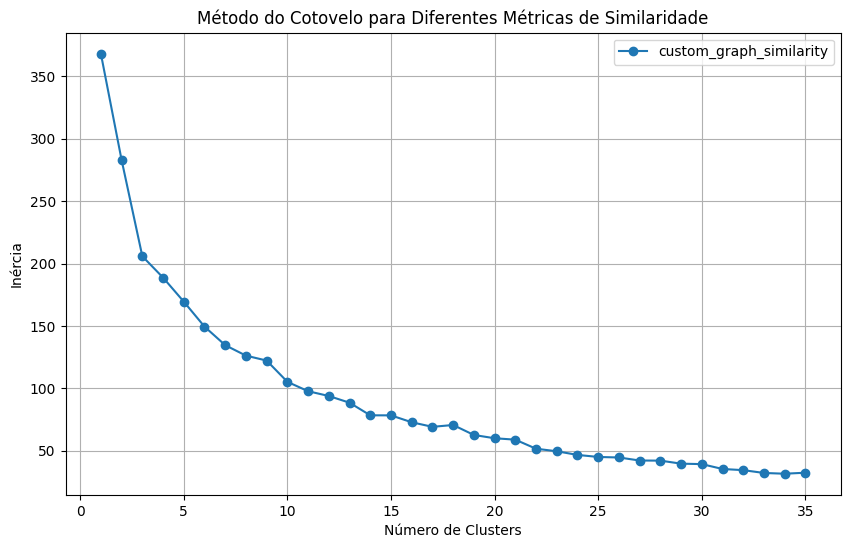

In [12]:
# Determinar o número ideal de clusters
inertia_results = elbow_method_similarity(grafos, max_clusters=35, similarity_metrics=['custom_graph_similarity'])

#### Encontrando o número de cluster pelo métoda da **Silhueta**

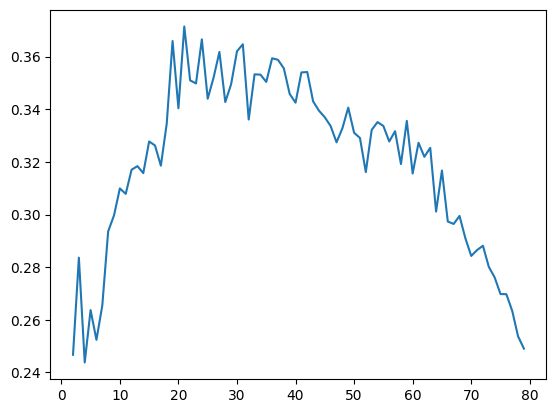

In [13]:
silhueta = []
for k in range(2, 80):
    clust = KMeans(n_clusters=k, n_init=10, random_state=42).fit(distance_matrix)
    silhueta.append(silhouette_score(distance_matrix, clust.labels_))
silhueta = np.array(silhueta)
silhueta.argmax()
plt.plot(list(range(2, 80)), silhueta)


#### **K-Means**

In [29]:
# Aplicar K-means para agrupar as coordenadas
optimal_k = 35  # Suponha que escolhemos 3 clusters com base no método do cotovelo
kmeans = KMeans(n_clusters=optimal_k)
labels = kmeans.fit_predict(distance_matrix)

In [39]:
# Aplicar K-means para agrupar as coordenadas
optimal_k_2 = 21  # Suponha que escolhemos 3 clusters com base no método do cotovelo
kmeans_2 = KMeans(n_clusters=optimal_k_2)
labels_2 = kmeans_2.fit_predict(distance_matrix)

In [31]:
def montar_clusters(grafos, labels, numero_k):
    clusters = dict()
    for num_cluster in range(0, numero_k):
        clusters = clusters | {num_cluster : []}
    lista_g = list(grafos.items())
    for i, label in enumerate(labels):
        numero_cluster = label
        clusters[numero_cluster].append(lista_g[i][0])
    return clusters

In [32]:
clusters = montar_clusters(grafos, labels, optimal_k)
clusters

{0: ['0219', '1145'],
 1: ['G1 L/A 02', '1233'],
 2: ['142001', '0924'],
 3: ['E119', '1302', '1060'],
 4: ['114802',
  '114803',
  '1214',
  '1146',
  '121101',
  '1107',
  '1229',
  '1148',
  '1118',
  '114801',
  '1123'],
 5: ['1137'],
 6: ['0324', '032401', '1538', '150801', '153802'],
 7: ['1220', '1207', '1238', '120701'],
 8: ['1224', '112501'],
 9: ['1612', 'LA G1 R3', '163702', '161201', '161202', '161203', '163703'],
 10: ['1639', '1635'],
 11: ['1534', '150802', '1643'],
 12: ['0320', '032002', '032001'],
 13: ['0344', '0342', '0102'],
 14: ['035401', '0354', '035402', 'LA G2 R2'],
 15: ['0301', '030102', '030101'],
 16: ['041001', '105501'],
 17: ['N035', 'N05701', 'N03501'],
 18: ['0132', '1102', '1215', '0131', '1334', '136802', '1236', '013201'],
 19: ['0345', '042201', '034501', '0422'],
 20: ['R020', 'R027.'],
 21: ['1133', '1103', '111401'],
 22: ['1062'],
 23: ['161101', '163701'],
 24: ['130501', '1347', '1114'],
 25: ['1144', '1143', '114401'],
 26: ['1616', '1652'

In [40]:
clusters_2 = montar_clusters(grafos, labels_2, optimal_k_2)
clusters_2

{0: ['G1 L/A 02', '1131', '1233'],
 1: ['R027.', '142001', '0924'],
 2: ['1616', '1652', '1622'],
 3: ['114802',
  '114803',
  '1214',
  '1146',
  '121101',
  '1107',
  '1229',
  '1148',
  '1118',
  '114801',
  '1123'],
 4: ['1639', '1635', '114402'],
 5: ['1051', '1302', '1060'],
 6: ['0301', '030102', '030101'],
 7: ['0345',
  '042201',
  '0324',
  '032401',
  '1538',
  '034501',
  '150801',
  '153802',
  '0422'],
 8: ['1220', '1207', '1238', '120701'],
 9: ['1133', '1103', '111401'],
 10: ['0132',
  '1102',
  '1225',
  '1215',
  '0131',
  '1334',
  'E119',
  '136802',
  '1236',
  '013201'],
 11: ['1612', 'LA G1 R3', '163702', '161201', '161202', '161203', '163703'],
 12: ['0219', '035401', '0354', '035402', 'LA G2 R2', '1145'],
 13: ['130501', '0426', '1347', '1114', '0412'],
 14: ['R020', '1144', '1143', '114401', '1137'],
 15: ['N035', 'N05701', 'N03501'],
 16: ['0320', '032002', '032001'],
 17: ['161101', '163701', '1534', '150802', '1643'],
 18: ['0915', '0344', '081301', '0914'

### Resultados

#### Montando o mapa

In [43]:
# Transforma RGB e Hexa
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def desenha_mapa(linhas):
    m = folium.Map([-13.004996, -38.476245], zoom_start=13)
    shapefile_path = 'https://raw.githubusercontent.com/jorgenery/ufba-mestrado/main/datasets/Bairros_Salvador.json'
    # https://raw.githubusercontent.com/jorgenery/ufba-mestrado/main/datasets/Bairros_Salvador.json
    map_data = gpd.read_file(shapefile_path)
    geojson_data = map_data.to_crs(epsg='4326').__geo_interface__
    response = requests.get(shapefile_path)
    response.raise_for_status()  # Verificar se o download foi bem-sucedido
    area = response.json()

    colormap = linear.YlOrRd_09.scale(0,162)
    colormap

    style_function = lambda x: {
    "fillColor": colormap(x['properties']['OBJECTID'])
    }
    folium.GeoJson(geojson_data, style_function=style_function).add_to(m)

    random.seed(10)


    for l1 in linhas:
        rgb = (random.randint(0,255),random.randint(0,255),random.randint(0,255))
        cor  = rgb_to_hex(rgb)
        ida = l1[l1['Sentido']=='I']
        volta = l1[l1['Sentido']=='V']
        pontos_ida = ida[['Latitude Ponto','Longitude Ponto']].to_numpy()
        pontos_volta = volta[['Latitude Ponto','Longitude Ponto']].to_numpy()
        line_weight = 4
        for j in range(len(pontos_ida)-1):
            coord = [pontos_ida[j],pontos_ida[j+1]]
            segment_width = (len(pontos_ida)-1) * (line_weight + 1)
            plugins.PolyLineOffset(
                coord,
                color=cor,
                weight=line_weight,
                opacity=1,
                offset=0,
            ).add_to(m)

        for j in range(len(pontos_volta)-1):
            coord = [pontos_volta[j],pontos_volta[j+1]]
            segment_width = (len(pontos_volta)-1) * (line_weight + 1)
            plugins.PolyLineOffset(
                coord,
                color=cor,
                weight=line_weight,
                opacity=1,
                offset=0,
            ).add_to(m)

        #corHexa = gerar_cor_hex()
        #print(corHexa)

        folium.plugins.AntPath(
            locations=pontos_ida, color=cor, reverse="True", dash_array=[2, 30]
        ).add_to(m)

        if (len(pontos_volta)>0):
            folium.plugins.AntPath(
                locations=pontos_volta, color=cor, reverse="False", dash_array=[2, 30]
            ).add_to(m)

        m.fit_bounds(m.get_bounds())

        mc = plugins.MarkerCluster()

        # for index, dados in l1.iterrows():
        #    cod_ponto = dados['CodPonto']
        #    endereco = dados['Endereço']
        #    linha = dados['Codigo Linha']
        #    html = f"""
        #      <b>Linha: {linha} </b><br>
        #      Outras Informações
        #      <p>Ponto: {cod_ponto} <br>
        #      <small>Endereço: {endereco}</small>
        #      </p>
        #    """
        #    iframe = branca.element.IFrame(html=html, width=200, height=150)
        #    popup = folium.Popup(iframe, max_width=500)
        #    m.add_child(folium.Marker([dados['Latitude Ponto'], dados['Longitude Ponto']],
        #        popup=popup,
        #        tooltip=dados['Codigo Linha']+" [ "+dados['Sentido']+" ] ("+str(dados['SequenciaPonto'])+")",
        #        icon=plugins.BeautifyIcon(
        #            border_color="#00ABDC",
        #            text_color="#00ABDC",
        #            number=dados['SequenciaPonto'],
        #            inner_icon_style="margin-top:0;",
        #            )))

    return m

In [53]:
dfg = []
for cluster in clusters[6]:
    dfg.append(df_pontos[df_pontos['Codigo Linha'].isin([cluster])])

desenha_mapa(dfg)

In [52]:
dfg = []
for cluster in clusters[7]:
    dfg.append(df_pontos[df_pontos['Codigo Linha'].isin([cluster])])

desenha_mapa(dfg)

In [56]:
dfg_042201 = df_pontos[df_pontos['Codigo Linha'].isin(['042201'])]
dfg_034501 = df_pontos[df_pontos['Codigo Linha'].isin(['034501'])]
dfg_0422 = df_pontos[df_pontos['Codigo Linha'].isin(['0422'])]

desenha_mapa([dfg_042201, dfg_034501, dfg_0422])

#### Gerando o gráfico de clusters

In [57]:
def exibir_grafico_dispersao(clusters, df_pontos_medios):
    for k_cluster, lista_Linha in clusters.items():
        pontos_filtrado = df_pontos_medios[df_pontos_medios['Codigo Linha'].isin(lista_Linha)]
        grupo1_x = pontos_filtrado['Latitude Ponto']
        grupo1_y = pontos_filtrado['Longitude Ponto']
        label_grupo = 'Grupo ' + str(k_cluster)
        plt.scatter(grupo1_x, grupo1_y, label=label_grupo)
    plt.title('Scartterplot de Clusters')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    # Exibindo o gráfico
    plt.show()

In [58]:
df_pontos[['Codigo Linha', 'Longitude Ponto', 'Latitude Ponto']]
df_group_pontos_medios = df_pontos[['Codigo Linha', 'Longitude Ponto', 'Latitude Ponto']].groupby('Codigo Linha', as_index=False).mean()
df_group_pontos_medios

,Codigo Linha,Longitude Ponto,Latitude Ponto
0,0102,-38.495588,-12.988475
1,0112,-38.505194,-12.974335
2,0116,-38.501119,-12.992179
3,0117,-38.495411,-12.990356
4,0131,-38.452950,-12.973075
...,...,...,...
598,S2,-38.444863,-12.953352
599,S6,-38.513813,-12.993508
600,T001,-38.464861,-12.944599
601,T014,-38.442721,-12.922280


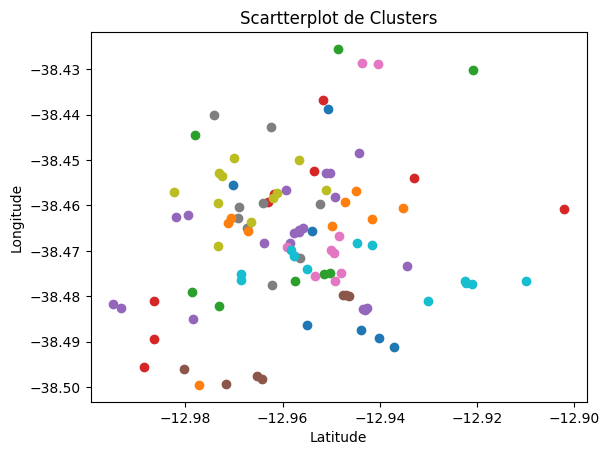

In [61]:
exibir_grafico_dispersao(clusters, df_group_pontos_medios)

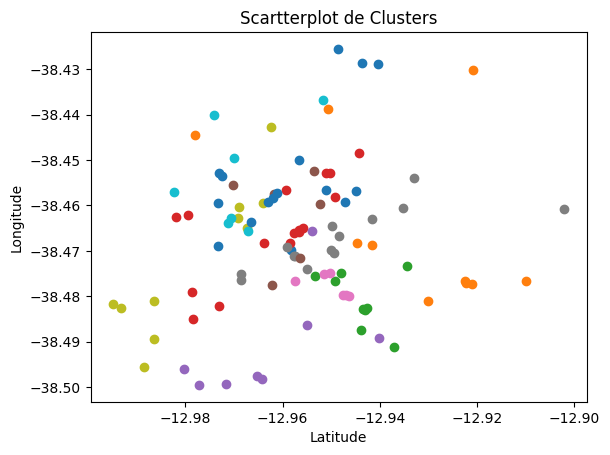

In [60]:
exibir_grafico_dispersao(clusters_2, df_group_pontos_medios)